In [1]:
import sys
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice
import matplotlib.ticker as ticker
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# sys.path.insert(0,'Repos/newcastle/air-quality/src/')
sys.path.insert(0,'../src')
from v0 import *

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days/'
metadata, sfeat, sensors = load_data(SHAPE_FOLDER, DATA_FOLDER)

variables =  {
        'sensors':['NO2','Temperature','Humidity','O3','CO','PM10'],
        'exogenous':['primary','trunk','motorway','signals','day','dow','hour'] #'street' = 'primary','trunk','motorway','traffic_signals'
}
sensors, metadata = resampling_sensors(sensors, metadata, variables, 'D')

# zx, zi = ingestion(sensors, metadata, sfeat, variables, 3, 'NO2', 'randomized')

In [3]:
sensors.loc['NO2'].head()

Value
Sensor Name    Timestamp            
aq_mesh1756150 2018-07-05  49.174784
               2018-07-06  35.604662
               2018-07-07  55.192007
               2018-07-08  35.020640
               2018-07-09  40.496704

In [15]:
a = sensors.loc[idx['NO2',:,'2018-07-09'],:].reset_index((0,2)).join(metadata)[['lon','lat','Value']]
P = a.loc[(a['lon']<-1.6) & (a['lat']<55) & (a['Value']<100)].values

X1 = P[:,:2]
z1 = P[:,2].reshape(-1,)

# 1. Inverse Distance Weighthing

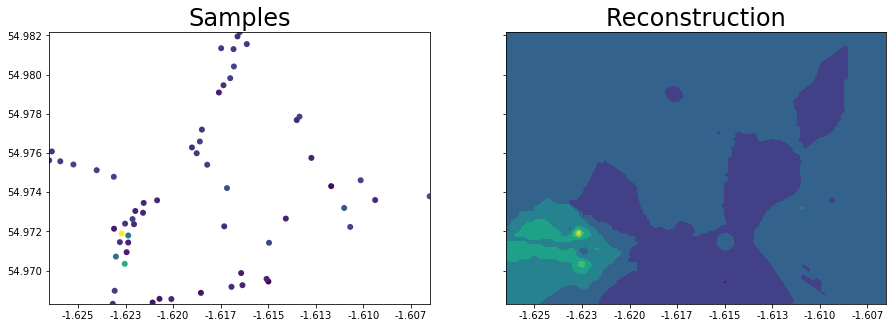

In [5]:
import idw


# 'train'
idw_tree = idw.tree(X1, z1)
# 'test'
xspacing = np.linspace(X1[:,0].min(), X1[:,0].max(), 100)
yspacing = np.linspace(X1[:,1].min(), X1[:,1].max(), 100)
X2 = np.meshgrid(xspacing, yspacing)
grid_shape = X2[0].shape
X2 = np.reshape(X2, (2, -1)).T

z2 = idw_tree(X2)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15,5))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax1.scatter(X1[:,0], X1[:,1], c=z1, linewidths=0)
ax1.set_title('Samples',fontsize=24)
ax2.contourf(xspacing, yspacing, z2.reshape(grid_shape))
ax2.set_title('Reconstruction',fontsize=24)
plt.xlim(X1[:,0].min(), X1[:,0].max())
plt.ylim(X1[:,1].min(), X1[:,1].max())
plt.show()

Evaluation

In [6]:
scores = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    z_train, z_test = z1[train_index], z1[test_index]
    
    # train
    idw_tree = idw.tree(X_train, z_train)
    
    # test
    z_pred = idw_tree(X_test)
    scores.append(r2_score(z_pred,z_test))
print(np.mean(scores))
scores

-8.905716199221601


[-7.955948616266008,
 -11.891503119813628,
 -9.011759111511664,
 -13.404642318480214,
 -2.2647278300364886]

# 2. Kriging

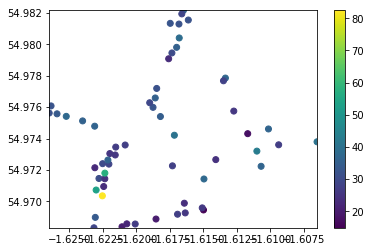

In [16]:
from geostatsmodels import utilities, variograms, model, kriging, geoplot

plt.scatter( X1[:,0], X1[:,1], c=z1)
plt.colorbar()
xmin, xmax = X1[:,0].min(), X1[:,0].max()
ymin, ymax = X1[:,1].min(), X1[:,1].max()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show();

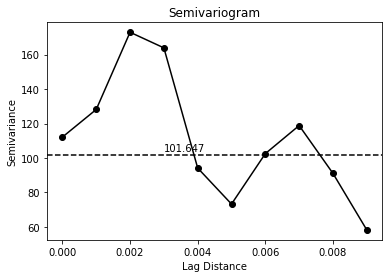

In [17]:
tolerance = 0.001
lags = np.arange( 0, 0.01, tolerance )
sill = np.var(z1)
geoplot.semivariogram(P, lags, tolerance);

In [18]:
covfct = model.covariance( model.spherical, ( 0.004, sill ) )

pt = [-1.610, 54.980]

kvalue, kvar = kriging.simple(P[:-10], covfct, pt, N=3)
print("{} +-{}".format(round(kvalue,2),round(kvar,2)))

kvalue, kvar = kriging.ordinary( P, covfct, pt, N=3 )
print("{} +-{}".format(round(kvalue,2),round(kvar,2)))

32.38 +-10.8
30.11 +-12.85


Evaluation

In [19]:
tolerance = 0.001
lags = np.arange( 0, 0.01, tolerance )


scores = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X1):
    X_train, X_test = X1[train_index], X1[test_index]
    z_train, z_test = z1[train_index], z1[test_index]
    
    # train
    covfct = model.covariance(model.spherical, (0.004, np.var(z_train)))

    # test
    z_pred = pd.DataFrame(X_test).apply(lambda x: kriging.simple(P.take(train_index,axis=0), covfct, x[[0,1]], N=1)[0] , axis=1).values
    scores.append(r2_score(z_pred,z_test))
print(np.mean(scores))
scores

-12.662556253204952


[-51.89324136540013,
 -0.5962082932880535,
 -3.867677921264204,
 -6.061718295848105,
 -0.8939353902242775]